<a href="https://colab.research.google.com/github/paulnord/ExampleCode/blob/main/Better_LSTM_fitting_periodic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Toy LSTM Fitting.  


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Parameters
num_samples = 10000  # Total number of samples
sequence_length = 200  # Length of each input sequence
frequency_range = (5, 75)  # Frequency range for sine wave
amplitude_range = (0.1, 5.0)  # Amplitude range for sine wave
phase_shift_range = (0, 2 * np.pi)  # Phase shift range for sine wave
noise_level = 1.0  # Standard deviation of added Gaussian noise

# Dataset split ratios
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

# Calculate dataset sizes
num_train = int(num_samples * train_ratio)
num_validation = int(num_samples * validation_ratio)
num_test = num_samples - num_train - num_validation

def generate_data(num_samples):
    inputs = []
    outputs = []

    for _ in range(num_samples):
        frequency = np.random.uniform(*frequency_range)
        amplitude = np.random.uniform(*amplitude_range)
        phase_shift = np.random.uniform(*phase_shift_range)

        # Generate sine wave
        x = np.linspace(0, 2 * np.pi, sequence_length)
        sine_wave = amplitude * np.sin(frequency * x / (2 * np.pi) + phase_shift)

        # Add noise
        sine_wave_noisy = sine_wave + np.random.normal(0, noise_level, size=sequence_length)

        # Append data
        inputs.append(sine_wave_noisy.tolist())  # Convert to list for proper CSV serialization
        outputs.append([frequency, amplitude, phase_shift])

    return inputs, np.array(outputs)

# Generate datasets
train_inputs, train_outputs = generate_data(num_train)
validation_inputs, validation_outputs = generate_data(num_validation)
test_inputs, test_outputs = generate_data(num_test)

# Normalize Outputs
output_scaler = MinMaxScaler(feature_range=(0, 1))
train_outputs = output_scaler.fit_transform(train_outputs)
validation_outputs = output_scaler.transform(validation_outputs)
test_outputs = output_scaler.transform(test_outputs)

# Save to CSV files
def save_to_csv(inputs, outputs, file_name):
    data = pd.DataFrame({
        'inputs': [','.join(map(str, input_row)) for input_row in inputs],  # Properly format inputs with commas
        'frequency': outputs[:, 0],
        'amplitude': outputs[:, 1],
        'phase_shift': outputs[:, 2],
    })
    data.to_csv(file_name, index=False)

save_to_csv(train_inputs, train_outputs, "train_data.csv")
save_to_csv(validation_inputs, validation_outputs, "validation_data.csv")
save_to_csv(test_inputs, test_outputs, "test_data.csv")

print("Data files created: train_data.csv, validation_data.csv, test_data.csv")


Data files created: train_data.csv, validation_data.csv, test_data.csv


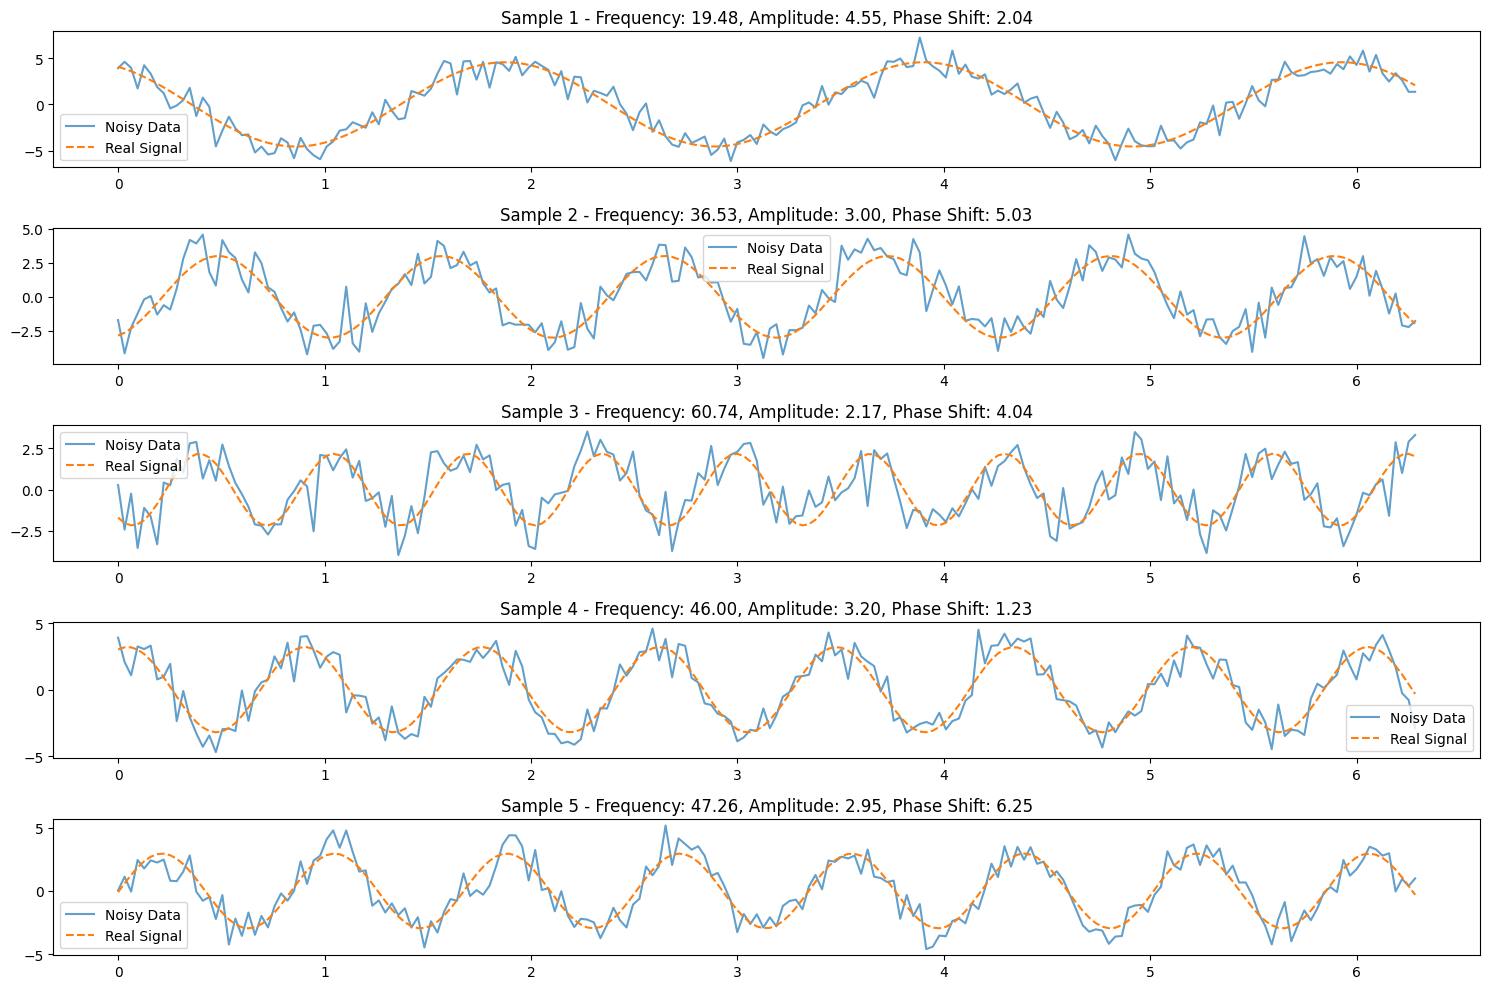

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reusing the load_data function
def load_data(file_name):
    data = pd.read_csv(file_name)

    # Parse inputs into a 2D NumPy array
    inputs = np.array(
        [np.array(eval(row)) if isinstance(row, str) else row for row in data["inputs"]]
    )

    # Extract outputs as a NumPy array
    outputs = data[["frequency", "amplitude", "phase_shift"]].values
    return inputs, outputs


# Load the training data
train_file = "train_data.csv"
inputs, outputs = load_data(train_file)

def inverse_normalize(normalized_values, min_val, max_val):
    """
    Reverses the normalization of a value scaled between [0, 1].

    Parameters:
    - normalized_values: The normalized value(s) (array or single value).
    - min_val: Minimum value of the original range.
    - max_val: Maximum value of the original range.

    Returns:
    - Original values rescaled to the given range.
    """
    return normalized_values * (max_val - min_val) + min_val



# Plot a few samples
num_samples_to_plot = 5
plt.figure(figsize=(15, 10))
x = np.linspace(0, 2 * np.pi, 200)  # X-axis for the sine wave

for i in range(num_samples_to_plot):
    noisy_data = inputs[i]
    frequency, amplitude, phase_shift = outputs[i]
    # Reverse normalization
    frequency = inverse_normalize(frequency, *frequency_range)
    amplitude = inverse_normalize(amplitude, *amplitude_range)
    phase_shift = inverse_normalize(phase_shift, *phase_shift_range)
    real_signal = amplitude * np.sin(frequency * x / (2 * np.pi) + phase_shift)

    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(x, noisy_data, label="Noisy Data", alpha=0.7)
    plt.plot(x, real_signal, label="Real Signal", linestyle="--")
    plt.title(f"Sample {i + 1} - Frequency: {frequency:.2f}, Amplitude: {amplitude:.2f}, Phase Shift: {phase_shift:.2f}")
    plt.legend()

plt.tight_layout()
plt.show()


Is GPU available?  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 196, 64)             │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 98, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 98, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 98, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 98, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,085,571 (4.14 MB)

 Trainable params: 1,085,571 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

None


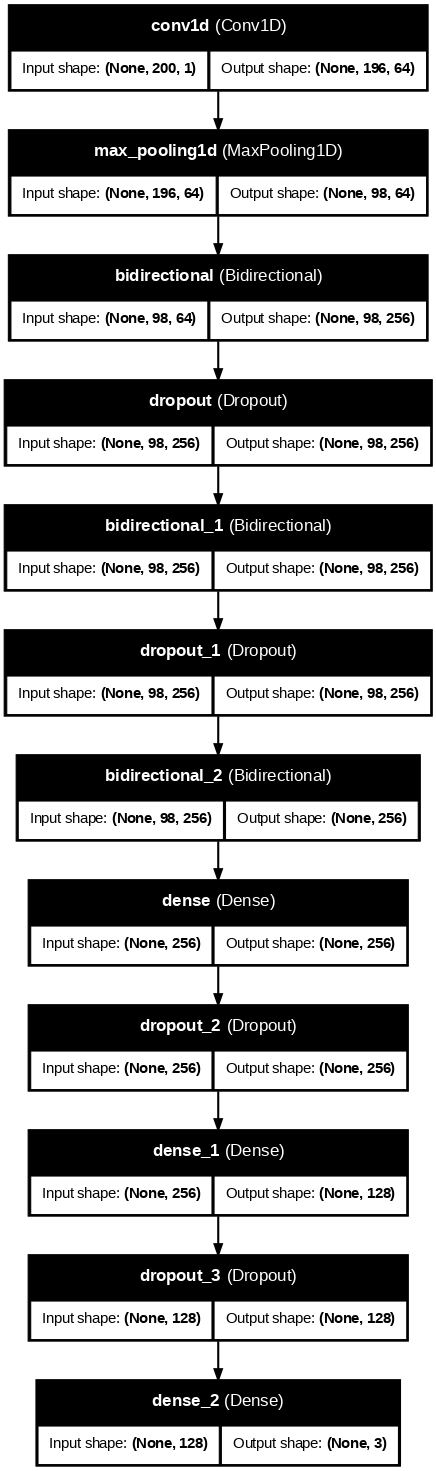

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - loss: 0.1006 - mae: 0.2427 - val_loss: 0.0282 - val_mae: 0.1186
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0371 - mae: 0.1450 - val_loss: 0.0222 - val_mae: 0.1051
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0325 - mae: 0.1324 - val_loss: 0.0181 - val_mae: 0.0913
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0273 - mae: 0.1201 - val_loss: 0.0162 - val_mae: 0.0832
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0255 - mae: 0.1137 - val_loss: 0.0158 - val_mae: 0.0797
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0235 - mae: 0.1077 - val_loss: 0.0148 - val_mae: 0.0779
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0217 - mae: 0.1041 - val_loss: 0.0132 - val_mae: 0.0658
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0225 - mae: 0.1048 - val_loss: 0.0129 - val_mae: 0.0674
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━

In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.config import list_physical_devices
from IPython.display import Image, display

# Check if GPU is available
gpu_available = list_physical_devices('GPU')
print("Is GPU available? ", gpu_available)

# Helper function to load data from CSV
def load_data(file_name):
    data = pd.read_csv(file_name)
    inputs = np.array([np.fromstring(row.strip("[]"), sep=",") for row in data["inputs"]])
    outputs = data[["frequency", "amplitude", "phase_shift"]].values
    return inputs, outputs

# Load datasets
train_inputs, train_outputs = load_data("train_data.csv")
validation_inputs, validation_outputs = load_data("validation_data.csv")
test_inputs, test_outputs = load_data("test_data.csv")

# Reshape inputs for LSTM: (samples, time_steps, features)
train_inputs = train_inputs.reshape(train_inputs.shape[0], train_inputs.shape[1], 1)
validation_inputs = validation_inputs.reshape(validation_inputs.shape[0], validation_inputs.shape[1], 1)
test_inputs = test_inputs.reshape(test_inputs.shape[0], test_inputs.shape[1], 1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, BatchNormalization

# Build the model
model = Sequential()

# Convolutional layer to extract local features
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(train_inputs.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))  # Downsample the sequence

# Stacked Bidirectional LSTM layers
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True)))
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, activation='tanh')))

# Dense layers for prediction
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3))  # Output layer for frequency, amplitude, phase_shift

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(model.summary())


# Generate a diagram of the model and display it inline
plot_file = "model_diagram.png"
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True, dpi=75)

# Display the diagram in Colab
display(Image(plot_file))

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_inputs, train_outputs,
    validation_data=(validation_inputs, validation_outputs),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate on the test set
test_loss, test_mae = model.evaluate(test_inputs, test_outputs)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Make predictions on the test set
predictions = model.predict(test_inputs)

# Save predictions and test outputs for comparison
predictions_df = pd.DataFrame(predictions, columns=["predicted_frequency", "predicted_amplitude", "predicted_phase_shift"])
actuals_df = pd.DataFrame(test_outputs, columns=["actual_frequency", "actual_amplitude", "actual_phase_shift"])
comparison_df = pd.concat([predictions_df, actuals_df], axis=1)
comparison_df.to_csv("predictions_vs_actuals.csv", index=False)

print("Predictions vs Actuals saved to predictions_vs_actuals.csv")


   predicted_frequency  predicted_amplitude  predicted_phase_shift  \
0             0.653907             0.698088               0.579230   
1             0.880200             0.332102               0.359149   
2             0.333331             0.168393               0.270914   
3             0.383932             0.270017               0.649538   
4             0.697762             0.807150               0.187984   

   actual_frequency  actual_amplitude  actual_phase_shift  
0          0.633988          0.759272            0.576620  
1          0.866001          0.328096            0.314320  
2          0.306576          0.156136            0.192268  
3          0.348940          0.346133            0.721793  
4          0.647163          0.806344            0.238739  


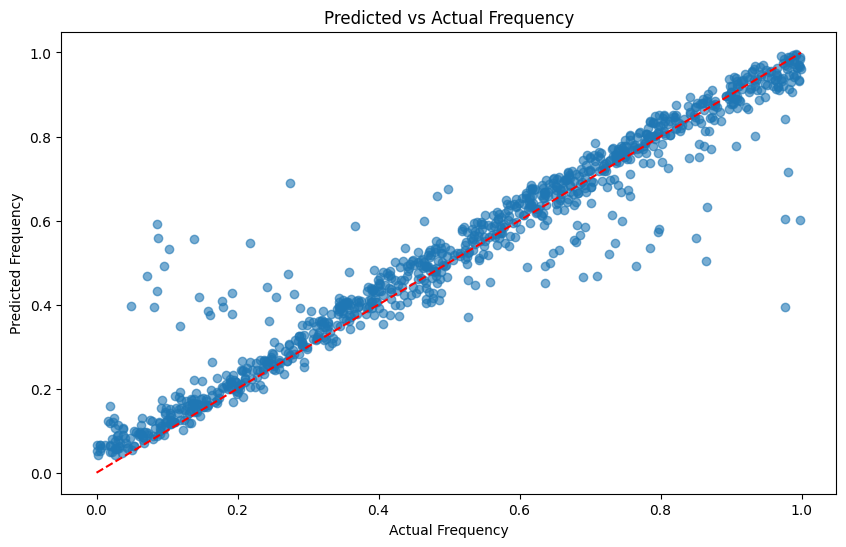

In [7]:
import pandas as pd

# Load the predictions vs actuals file
file_name = "predictions_vs_actuals.csv"
comparison_df = pd.read_csv(file_name)

# Display the predictions vs actuals data
print(comparison_df.head())  # Show the first few rows of the dataset

# Optionally, visualize the data
import matplotlib.pyplot as plt

# Plot predicted vs actual frequencies
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df["actual_frequency"], comparison_df["predicted_frequency"], alpha=0.6)
plt.plot([comparison_df["actual_frequency"].min(), comparison_df["actual_frequency"].max()],
         [comparison_df["actual_frequency"].min(), comparison_df["actual_frequency"].max()],
         color='red', linestyle='--')
plt.title("Predicted vs Actual Frequency")
plt.xlabel("Actual Frequency")
plt.ylabel("Predicted Frequency")
plt.show()

# Similarly, you can create plots for amplitude and phase shift:
# Uncomment and repeat for amplitude and phase shift if desired
# Replace "frequency" with "amplitude" or "phase_shift" in column names


   predicted_frequency  predicted_amplitude  predicted_phase_shift  \
0             0.653907             0.698088               0.579230   
1             0.880200             0.332102               0.359149   
2             0.333331             0.168393               0.270914   
3             0.383932             0.270017               0.649538   
4             0.697762             0.807150               0.187984   

   actual_frequency  actual_amplitude  actual_phase_shift  
0          0.633988          0.759272            0.576620  
1          0.866001          0.328096            0.314320  
2          0.306576          0.156136            0.192268  
3          0.348940          0.346133            0.721793  
4          0.647163          0.806344            0.238739  


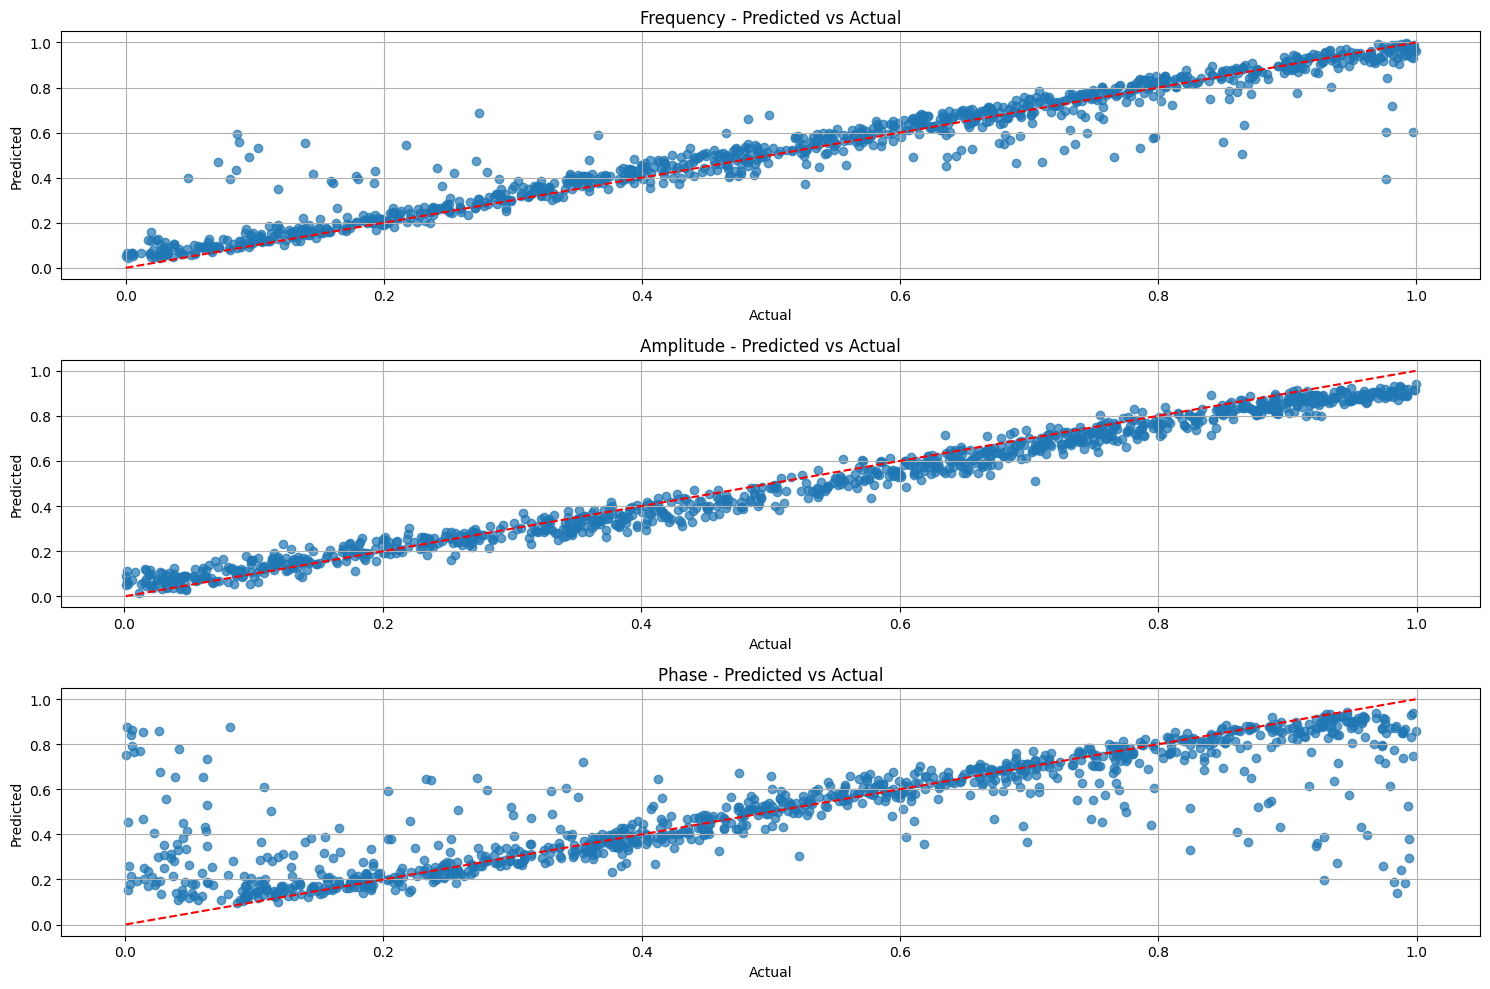

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the predictions vs actuals data
predictions_file = "predictions_vs_actuals.csv"
data = pd.read_csv(predictions_file)

# Display the predictions vs actuals data
print(data.head())  # Show the first few rows of the dataset

# Extract columns for plotting
predicted_columns = ["predicted_frequency", "predicted_amplitude", "predicted_phase_shift"]
actual_columns = ["actual_frequency", "actual_amplitude", "actual_phase_shift"]

# Plot each correlation
plt.figure(figsize=(15, 10))

for i, (predicted, actual) in enumerate(zip(predicted_columns, actual_columns)):
    plt.subplot(3, 1, i + 1)
    plt.scatter(data[actual], data[predicted], alpha=0.7)
    plt.plot(
        [data[actual].min(), data[actual].max()],
        [data[actual].min(), data[actual].max()],
        color='red', linestyle='--'
    )
    plt.title(f"{actual.split('_')[1].capitalize()} - Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)

plt.tight_layout()
plt.show()

